# Programming Homework 1

## Instructions

- Do not import other libraries. You are only allowed to use Math, Numpy, Scipy packages which are already imported in the file.
- Please follow the type annotations. There are some type annotations of the parameters of function calls and return values. Please use Python 3.5 or 3.6 (for full support of typing annotations). You can use Numpy/Scipy inside the function.  You have to make the functions’ return values match the required type.
- In this programming assignment you will to implement **Linear Regression**, **k-Nearest Neighbours*, and *Perceptron algorithm**. We provide the bootstrap code and you are expected to complete the **classes** and **functions**.
- Only modifications in files {`hw1_knn.py`, `hw1_lr.py`, `hw1_perceptron.py`, `utils.py`} will be accepted and graded. All other modifications will be ignored.

# Problem 1: Linear Regression

## Part 1.1 Implementation

**Implement** the classes in file *hw1_lr.py*.

    - LinearRegression
    - LinearRegressionWithL2Loss
   
and the function in file *utils.py*:
    
    - mean_squared_error

For linear regression with l2 loss (a.k.a. Ridge loss), here are two useful links: 

- [a tutorial blog](https://goo.gl/iTX39z)
- [a lecture slide](http://www.stat.cmu.edu/~ryantibs/datamining/lectures/16-modr1.pdf).

In [51]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
from hw1_lr import LinearRegression, LinearRegressionWithL2Loss
from utils import mean_squared_error


import matplotlib.pyplot as plt
# you can change the backend here if needed
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1.2 Sanity test

Do the following steps, as a simple test to check your model works correctly.

- Load data (features and values) from function `generate_data_part_1`.
- Create a LinearRegression model.
- Train the model using the loaded data.
- Calculate the MSE metric by your implementation of the mean squared error function.


In [52]:
from data import generate_data_part_1
features, values = generate_data_part_1()

In [53]:
model = LinearRegression(nb_features=1)
model.train(features, values)

mse = mean_squared_error(values, model.predict(features))
print('[part 1.2]\tmse: {mse:.5f}'.format(mse=mse))

[part 1.2]	mse: 0.00175


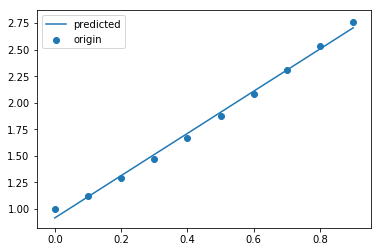

In [54]:
plt.scatter([x[0] for x in features], values, label='origin');
plt.plot([x[0] for x in features], model.predict(features), label='predicted');
plt.legend()

## Part 1.3 Feature Engineering
In this part, we are following the same procedure as that in part 

a). First we will try the same process as above.
We will try two cases : 
- No extra features
- Adding polynomial features

### Part 1.3.1 No extra features

In [55]:
from data import generate_data_part_2
features, values = generate_data_part_2()

In [56]:
model = LinearRegression(nb_features=1)
model.train(features, values)

mse = mean_squared_error(values, model.predict(features))
print('[part 1.3.1]\tmse: {mse:.5f}'.format(mse=mse))

[part 1.3.1]	mse: 0.39997


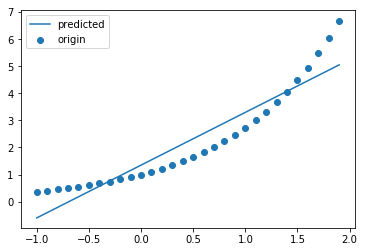

In [57]:
plt.scatter([x[0] for x in features], values, label='origin');
plt.plot([x[0] for x in features], model.predict(features), label='predicted');
plt.legend()

###  Part 1.3.2 Adding polynomial features

Note that in that synthetic dataset, the value is actually not linear with the feature (it is exponential). Inspired by Taylor expansion, we are going to add some polynomial features based on existing features.
More specifically, support 
$${\vec {x}} = [x_1, ..., x_n]$$
is the feature vector of one sample (whose value is $y$). Instead of modeling the relationship between $\vec{x}$ and $y$, we modeling the relationship of $y$ and $\vec{x'}$, where (suppose we are adding up to $k$-th degree polynomials)

$${\vec {x'}}_k = [x_1 , x_2 , ..., x_n , x_{21} , ..., x_{2n}, ..., x_{k1}, ..., x_{kn} ]. $$

where $x_{ki} = x_i^k$

Repeat the 4 steps listed in Part 1.2, then report the MSE value on training set and model weights for the following three cases: $k = 2, k = 4, k = 8$ (for all numbers, print 6 digits after the decimal point). 

### !!! Make sure that features’s polynomials follow the order in the above equation.

[part 1.3.2]	k: 2	mse: 0.02315
[part 1.3.2]	k: 4	mse: 0.00002
[part 1.3.2]	k: 8	mse: 0.00000


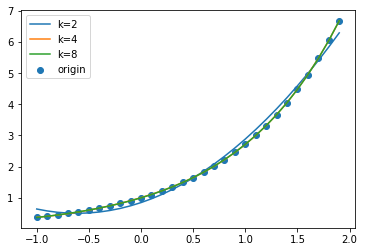

In [58]:
from utils import polynomial_features
features, values = generate_data_part_2()
plt.scatter([x[0] for x in features], values, label='origin');

for k in [2, 4, 8]:
    features_extended = polynomial_features(features, k)
    model = LinearRegression(nb_features=k)
    model.train(features_extended, values)
    mse = mean_squared_error(values, model.predict(features_extended))
    print('[part 1.3.2]\tk: {k:d}\tmse: {mse:.5f}'.format(k=k, mse=mse))
    plt.plot([x[0] for x in features], model.predict(features_extended), label='k={k}'.format(k=k));
plt.legend()

## Part 1.4 Train, validation, test

### Data processing 

Do the following steps:

- Load data (features and values) from function generate data part 3. It’s a classification dataset, but we just use it as a regression dataset in this assignment.
- Check that there are 150 data samples and each sample have a feature vector of length 4.
- Split the whole data set into three parts:
    - the train set contains first 100 samples (0th - 99th samples),
    - the validation set contains the next 20 samples (100th - 119th samples),
    - the test set contains the rest 30 samples (120th - 149th samples).

In [59]:
from data import generate_data_part_3
features, values = generate_data_part_3()

train_features, train_values = features[:100], values[:100]
valid_features, valid_values = features[100:120], values[100:120]
test_features, test_values = features[120:], values[120:]

assert len(train_features) == len(train_values) == 100
assert len(valid_features) == len(valid_values) == 20
assert len(test_features) == len(test_values) == 30

### Part 1.4.1 LinearRegression

### Hyper-parameter and model selection 

For linear regression model with extra polynomial features, $k$ is a hyper-parameter. 
To choose the best one, we have to 

    - train a model with that hyper-parameter based on the train set, 
    - calculate its performance on the validation set
    - select the best hyper-parameter (the trained model has the best performance on validation set). 
    
In this task, we only search $k$ among the set {1, 3, 10}. 

In [60]:
best_mse, best_k = 1e10, -1
for k in [1, 3, 10]:
    train_features_extended = polynomial_features(train_features, k)
    model = LinearRegression(nb_features=4*k)
    model.train(train_features_extended, train_values)
    train_mse = mean_squared_error(train_values, model.predict(train_features_extended))

    valid_features_extended = polynomial_features(valid_features, k)
    valid_mse = mean_squared_error(valid_values, model.predict(valid_features_extended))
    print('[part 1.4.1]\tk: {k:d}\t'.format(k=k) + 
          'train mse: {train_mse:.5f}\tvalid mse: {valid_mse:.5f}'.format(
              train_mse=train_mse, valid_mse=valid_mse))

    if valid_mse < best_mse:
        best_mse, best_k = valid_mse, k

[part 1.4.1]	k: 1	train mse: 0.00909	valid mse: 0.33937
[part 1.4.1]	k: 3	train mse: 0.00261	valid mse: 3.28984
[part 1.4.1]	k: 10	train mse: 0.20826	valid mse: 201331.52500


In [61]:
combined_features_extended = polynomial_features(train_features + valid_features, best_k)
model = LinearRegression(nb_features=best_k)
model.train(combined_features_extended, train_values + valid_values)

test_features_extended = polynomial_features(test_features, best_k)
test_mse = mean_squared_error(test_values, model.predict(test_features_extended))
print('[part 1.4.1 Linear Regression]\tbest_k: {best_k:d}\ttest mse: {test_mse:.5f}'.format(
    best_k=best_k, test_mse=test_mse))

[part 1.4.1 Linear Regression]	best_k: 1	test mse: 0.13021


### Part 1.4.2 Linear Regression With L2 Loss (Ridge Regression)

For Ridge (linear regression with l2 loss) Regression, we still need to search $k$ among {1, 3, 10}.
$\alpha$ is also a hyper-parameter, in this task, we search $\alpha$ among the set {0.01, 0.1, 1, 10}.

In [62]:
from itertools import product

best_mse, best_k, best_alpha = 1e10, -1, -1
for k, alpha in product([1, 3, 10], [0.01, 0.1, 1, 10]):
    train_features_extended = polynomial_features(train_features, k)
    model = LinearRegressionWithL2Loss(nb_features=k, alpha=alpha)
    model.train(train_features_extended, train_values)
    train_mse = mean_squared_error(train_values, model.predict(train_features_extended))

    valid_features_extended = polynomial_features(valid_features, k)
    valid_mse = mean_squared_error(valid_values, model.predict(valid_features_extended))
    print('[part 1.4.2]\tk: {k:d}\talpha: {alpha}\t'.format(k=k, alpha=alpha) +
          'train mse: {train_mse:.5f}\tvalid mse: {valid_mse:.5f}'.format(
              train_mse=train_mse, valid_mse=valid_mse))

    if valid_mse < best_mse:
        best_mse, best_k, best_alpha = valid_mse, k, alpha

[part 1.4.2]	k: 1	alpha: 0.01	train mse: 0.00909	valid mse: 0.33964
[part 1.4.2]	k: 1	alpha: 0.1	train mse: 0.00911	valid mse: 0.34196
[part 1.4.2]	k: 1	alpha: 1	train mse: 0.00955	valid mse: 0.35604
[part 1.4.2]	k: 1	alpha: 10	train mse: 0.01058	valid mse: 0.40436
[part 1.4.2]	k: 3	alpha: 0.01	train mse: 0.00270	valid mse: 3.33796
[part 1.4.2]	k: 3	alpha: 0.1	train mse: 0.00288	valid mse: 2.69893
[part 1.4.2]	k: 3	alpha: 1	train mse: 0.00336	valid mse: 2.12091
[part 1.4.2]	k: 3	alpha: 10	train mse: 0.00412	valid mse: 1.56060
[part 1.4.2]	k: 10	alpha: 0.01	train mse: 0.00019	valid mse: 15773.72437
[part 1.4.2]	k: 10	alpha: 0.1	train mse: 0.00027	valid mse: 9165.65656
[part 1.4.2]	k: 10	alpha: 1	train mse: 0.00038	valid mse: 2407.71224
[part 1.4.2]	k: 10	alpha: 10	train mse: 0.00084	valid mse: 1519.90973


In [63]:
combined_features_extended = polynomial_features(train_features + valid_features, best_k)
model = LinearRegressionWithL2Loss(nb_features=best_k, alpha=best_alpha)
model.train(combined_features_extended, train_values + valid_values)

test_features_extended = polynomial_features(test_features, best_k)
test_mse = mean_squared_error(test_values, model.predict(test_features_extended))
print('[part 1.4.2]\tbest_k: {best_k:d}\tbest_alpha: {best_alpha:f}\t'.format(
    best_k=best_k, best_alpha=best_alpha) +
      'test mse: {test_mse:.5f}'.format(test_mse=test_mse))

[part 1.4.2]	best_k: 1	best_alpha: 0.010000	test mse: 0.13018


## Problem 2: K-nearest neighbor (KNN) for binary classification

#### Some notes

In this task, we will use three distance functions: (we removed the vector symbol for simplicity)

- Euclidean distance:  $$d(x, y) = \sqrt{\langle x - y, x - y \rangle}$$
- Inner product distance: $$d(x, y ) = \langle x, y \rangle$$
- Gaussian kernel distance: 
    $$d(x, y ) = - \exp({−\frac 12 \langle x - y, x - y \rangle}) $$


F1-score is a important metric for binary classification, as sometimes the accuracy metric has the false positive (a good example is in MLAPP book 2.2.3.1 “Example: medical diagnosis”, Page 29).

### Part 2.1 Distance Functions

Implement the class in file *hw1_knn.py*
    - KNN
    
and the functions in *utils.py*    
    - f1_score
    - euclidean_distance
    - inner_product_distance
    - gaussian_kernel_distance

In [64]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hw1_knn import KNN
from utils import euclidean_distance, gaussian_kernel_distance, inner_product_distance
from utils import f1_score

distance_funcs = {
    'euclidean': euclidean_distance,
    'gaussian': gaussian_kernel_distance,
    'inner_prod': inner_product_distance,
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data processing 

Do the following steps:

- Load data (features and values) from function generate data cancer
- Check that there are 569 data samples and each sample have a feature vector of length 30.
- Split the whole data set into three parts:
     - the train set contains first 400 samples (0th - 399th samples),
     - the validation set contains the next 60 samples (400th - 459th samples),
     - the test set contains the rest 109 samples (460th - 568th samples).

In [65]:
from data import generate_data_cancer
features, labels = generate_data_cancer()

train_features, train_labels = features[:400], labels[:400]
valid_features, valid_labels = features[400:460], labels[400:460]
test_features, test_labels = features[460:], labels[460:]

assert len(train_features) == len(train_labels) == 400
assert len(valid_features) == len(valid_labels) == 60
assert len(test_features) == len(test_labels) == 109

#### Model selection 
In kNN model, the parameter k is a hyper-parameter. In this task, we only search k among {1, 3, 10, 20, 50}.

In [66]:
for name, func in distance_funcs.items():
    best_f1_score, best_k = -1, 0
    for k in [1, 3, 10, 20, 50]:
        model = KNN(k=k, distance_function=func)
        model.train(train_features, train_labels)
        train_f1_score = f1_score(
            train_labels, model.predict(train_features))

        valid_f1_score = f1_score(
            valid_labels, model.predict(valid_features))
        print('[part 2.1] {name}\tk: {k:d}\t'.format(name=name, k=k) + 
              'train: {train_f1_score:.5f}\t'.format(train_f1_score=train_f1_score) +
              'valid: {valid_f1_score:.5f}'.format(valid_f1_score=valid_f1_score))

        if valid_f1_score > best_f1_score:
            best_f1_score, best_k = valid_f1_score, k

    model = KNN(k=best_k, distance_function=func)
    model.train(train_features + valid_features,
                train_labels + valid_labels)
    test_f1_score = f1_score(test_labels, model.predict(test_features))
    print()
    print('[part 2.1] {name}\tbest_k: {best_k:d}\t'.format(name=name, best_k=best_k) +
          'test f1 score: {test_f1_score:.5f}'.format(test_f1_score=test_f1_score))
    print()

[part 2.1] euclidean	k: 1	train: 1.00000	valid: 0.96774
[part 2.1] euclidean	k: 3	train: 0.95879	valid: 0.97872
[part 2.1] euclidean	k: 10	train: 0.95896	valid: 0.97872
[part 2.1] euclidean	k: 20	train: 0.95054	valid: 0.97872
[part 2.1] euclidean	k: 50	train: 0.92405	valid: 0.96774

[part 2.1] euclidean	best_k: 3	test f1 score: 0.95000

[part 2.1] gaussian	k: 1	train: 1.00000	valid: 0.95652
[part 2.1] gaussian	k: 3	train: 0.95614	valid: 0.97872
[part 2.1] gaussian	k: 10	train: 0.76174	valid: 0.86792
[part 2.1] gaussian	k: 20	train: 0.93694	valid: 0.96774
[part 2.1] gaussian	k: 50	train: 0.74426	valid: 0.87850

[part 2.1] gaussian	best_k: 3	test f1 score: 0.87209

[part 2.1] inner_prod	k: 1	train: 0.72408	valid: 0.87850
[part 2.1] inner_prod	k: 3	train: 0.72408	valid: 0.87850
[part 2.1] inner_prod	k: 10	train: 0.72408	valid: 0.87850
[part 2.1] inner_prod	k: 20	train: 0.72408	valid: 0.87850
[part 2.1] inner_prod	k: 50	train: 0.72408	valid: 0.87850

[part 2.1] inner_prod	best_k: 1	test f1

### Part 2.2 Data transformation

We are going to add one more step (data transformation) in the data processing part and see how it works. 
Sometimes, normalization plays an important role to make a machine learning model work (check term “Feature scaling” in wiki).

Here, we take two different data transformation approaches.

#### Normalizing the feature vector 

This one is simple but some times may work well. Given a feature vector $x$, the normalized feature vector is given by 

$$ x' = \frac x {\sqrt{\langle x, x \rangle}} $$
If a vector is a all-zero vector, we let the normalized vector also be a all-zero vector.


#### Min-max scaling the feature matrix

The above normalization is data independent, that is to say, the output of the normalization function doesn’t depend on the rest training data. However, sometimes it would be helpful to do data dependent normalization. One thing to note is that, when doing data dependent normalization, we can only use training data, as the test data is assumed to be unknown during training (at least for most classification tasks).

The min-max scaling works as follows: after min-max scaling, all values of training data’s feature vectors are in the given range.
Note that this doesn’t mean the values of the validation/test data’s fea- tures are all in that range, because the validation/test data may have dif- ferent distribution as the training data.

**Implement** the functions in *utils.py*    
    - normalize
    - min_max_scale

In [67]:
from utils import NormalizationScaler, MinMaxScaler

scaling_classes = {
    'min_max_scale': MinMaxScaler,
    'normalize': NormalizationScaler,
}

#### Model selection

Repeat the model selection part in part 2.2.

In [68]:
for scaling_name, scaling_class in scaling_classes.items():
    for name, func in distance_funcs.items():
        scaler = scaling_class()
        train_features_scaled = scaler(train_features)
        valid_features_scaled = scaler(valid_features)

        best_f1_score, best_k = -1, 0
        for k in [1, 3, 10, 20, 50]:
            model = KNN(k=k, distance_function=func)
            model.train(train_features_scaled, train_labels)
            train_f1_score = f1_score(
                train_labels, model.predict(train_features_scaled))
            
            valid_f1_score = f1_score(
                valid_labels, model.predict(valid_features_scaled))
            print('[part 2.2] {name}\t{scaling_name}\tk: {k:d}\t'.format(name=name, scaling_name=scaling_name, k=k) +
                  'train: {train_f1_score:.5f}\t'.format(train_f1_score=train_f1_score) + 
                  'valid: {valid_f1_score:.5f}'.format(valid_f1_score=valid_f1_score))

            if valid_f1_score > best_f1_score:
                best_f1_score, best_k = valid_f1_score, k

        scaler = scaling_class()
        combined_features_scaled = scaler(train_features + valid_features)
        test_features_scaled = scaler(test_features)

        model = KNN(k=best_k, distance_function=func)
        model.train(combined_features_scaled, train_labels + valid_labels)
        test_f1_score = f1_score(test_labels, model.predict(test_features_scaled))
        print()
        print('[part 2.2] {name}\t{scaling_name}\t'.format(name=name, scaling_name=scaling_name) +
              'best_k: {best_k:d}\ttest: {test_f1_score:.5f}'.format(best_k=best_k, test_f1_score=test_f1_score))
        print()

[part 2.2] euclidean	min_max_scale	k: 1	train: 1.00000	valid: 0.95652
[part 2.2] euclidean	min_max_scale	k: 3	train: 0.98253	valid: 0.98947
[part 2.2] euclidean	min_max_scale	k: 10	train: 0.98261	valid: 0.97872
[part 2.2] euclidean	min_max_scale	k: 20	train: 0.97826	valid: 0.97872
[part 2.2] euclidean	min_max_scale	k: 50	train: 0.95726	valid: 0.98947

[part 2.2] euclidean	min_max_scale	best_k: 3	test: 0.96296

[part 2.2] gaussian	min_max_scale	k: 1	train: 1.00000	valid: 0.95652
[part 2.2] gaussian	min_max_scale	k: 3	train: 0.98253	valid: 0.98947
[part 2.2] gaussian	min_max_scale	k: 10	train: 0.98261	valid: 0.97872
[part 2.2] gaussian	min_max_scale	k: 20	train: 0.97826	valid: 0.97872
[part 2.2] gaussian	min_max_scale	k: 50	train: 0.95726	valid: 0.98947

[part 2.2] gaussian	min_max_scale	best_k: 3	test: 0.96296

[part 2.2] inner_prod	min_max_scale	k: 1	train: 0.72408	valid: 0.87850
[part 2.2] inner_prod	min_max_scale	k: 3	train: 0.72408	valid: 0.87850
[part 2.2] inner_prod	min_max_scale	

## Problem 3: Perceptron Problem 
In this problem we will implement perceptron algorithm. Recall that perceptron algorithm can converge only when the data is linearly seperable. 

### Objective 
Implement the class `Perceptron` in file `hw1_perceptron.py`.

#### Some notes
- Perceptron update rule is whenever algorithm makes a mistake update
weights as

$$w ← w + \frac{y_i x_i}{\|x_i\|}$$

- Perceptron algorithm as discussed only works for linearly seperable
data. In this problem you will see that it is indeed the case.
- For data which is not linearly seperable there is class of model/classifiers
called maximum margin classifiers which will be discussed later.

In [69]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt 
from data import generate_data_perceptron 
from hw1_perceptron import Perceptron
import numpy as np

## To clearly visualize the problem, we just use 2 features for now
## y = f(x1,x2)

nb_features=2
model = Perceptron(nb_features=nb_features)
x, y = generate_data_perceptron(nb_features=nb_features, seperation=2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


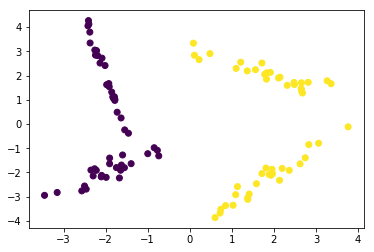

In [70]:
# plot and satisfy your self that data is linearly seperable
x1 = []
x2 = []
for i in x:
    x1.append(i[1])
    x2.append(i[2])
plt.scatter(x1, x2, c=y)
plt.show()

Now complete the train & predict function in Perceptron class. You algorithm should find the seperating hyperplane and model.predict should give all the labels correct.   

In [71]:
converged = model.train(x, y)
y_hat = model.predict(x) 
correct = 0 
for i, y_real in enumerate(y):
    if (y_hat[i]==y_real):
        correct = correct + 1
    
print ("Accuracy on training data is {}".format(correct*100/len(y)))
print (correct)


Accuracy on training data is 100.0
100


Plot the data points and seperating hyperplane to see your perceptron has actually learnt correct seperating plane
  

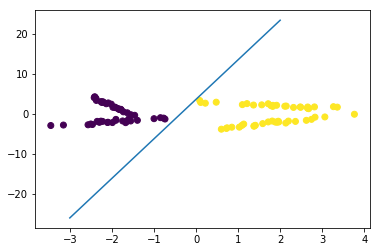

In [72]:
w = model.get_weights()
x1 = []
x2 = []
for i in x:
    x1.append(i[1])
    x2.append(i[2])
plt.scatter(x1, x2, c=y)
plt.plot(np.arange(-3, 3, 1), -(w[1] * np.arange(-3, 3, 1) + w[0]) / w[2])
plt.show()

Now we will try a 80-20 split of data into train and test and see what happens.

Try shuffling the data and compare the results.

In [73]:
## TODO : Try shuffling the data

model.reset()
print (model.get_weights())
test_x, train_x = x[80:], x[:80]
test_y, train_y = y[80:], y[:80]
converged = model.train(train_x, train_y)
y_hat = model.predict(test_x) 
correct = 0 
for i, y_real in enumerate(test_y):
    if (y_hat[i]==y_real):
        correct = correct + 1
    
print ("Accuracy on testing data is {}".format(correct*100/len(test_y)))


[0, 0, 0]
Accuracy on testing data is 100.0


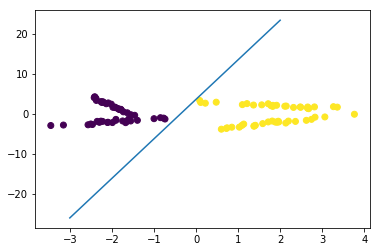

In [74]:
w = model.get_weights()
x1 = []
x2 = []
for i in x:
    x1.append(i[1])
    x2.append(i[2])
plt.scatter(x1, x2, c=y)
plt.plot(np.arange(-3, 3, 1), -(w[1] * np.arange(-3, 3, 1) + w[0]) / w[2])
plt.show()

### What if data is not linearly seperable

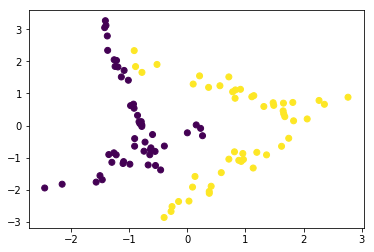

In [75]:
nb_features=2
model = Perceptron(nb_features=nb_features)
x, y = generate_data_perceptron(nb_features=nb_features, seperation=1)
# plot and satisfy your self that data is not linearly seperable
x1 = []
x2 = []
for i in x:
    x1.append(i[1])
    x2.append(i[2])
plt.scatter(x1, x2, c=y)
plt.show()

In [76]:
converged = model.train(x, y)
if (converged):
    print ('Algorithm has converged')
else:
    print ('Algorithm didnot converge')
    
y_hat = model.predict(x) 
correct = 0 
for i, y_real in enumerate(y):
    if (y_hat[i]==y_real):
        correct = correct + 1
    
print ("Accuracy on training data is {}".format(correct*100/len(y)))
print (correct)

Algorithm didnot converge
Accuracy on training data is 92.0
92


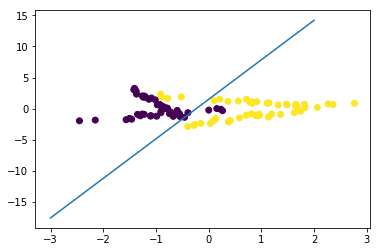

In [77]:
w = model.get_weights()
x1 = []
x2 = []
for i in x:
    x1.append(i[1])
    x2.append(i[2])
plt.scatter(x1, x2, c=y)
plt.plot(np.arange(-3, 3, 1), -(w[1] * np.arange(-3, 3, 1) + w[0]) / w[2])
plt.show()

Finding a seperating plane when data is d dimensional. Note that we visualize only first two features, so data might not look seperable but might really be seperable

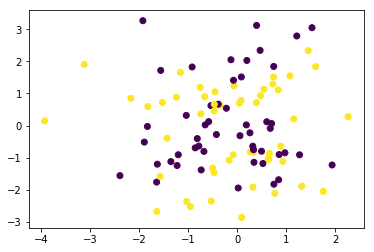

In [78]:
nb_features=10
model = Perceptron(nb_features=nb_features)

# use seperation=1 for non-seperable 
# use seperation=2 for seperable 

x, y = generate_data_perceptron(nb_features=nb_features, seperation=1)
# plot first two dimensions
x1 = []
x2 = []
for i in x:
    x1.append(i[1])
    x2.append(i[2])
plt.scatter(x1, x2, c=y)
plt.show()

In [79]:
converged = model.train(x, y)
if (converged):
    print ('Algorithm has converged')
else:
    print ('Algorithm didnot converge')
    
y_hat = model.predict(x) 
correct = 0 
for i, y_real in enumerate(y):
    if (y_hat[i]==y_real):
        correct = correct + 1
    
print ("Accuracy on training data is {}".format(correct*100/len(y)))
print (correct)

Algorithm didnot converge
Accuracy on training data is 77.0
77
